In [1]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
# Render the figure in a notebook:
%matplotlib inline  

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import plot_tree

from sklearn import metrics

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F

from torchmetrics.classification import Accuracy
from torchmetrics.classification import Recall
from torchmetrics import R2Score
from torchmetrics import MeanAbsoluteError

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
x_train = pd.read_csv('../no_nontoxic_nans_X_train.csv', index_col=0)
y_train = pd.read_csv('../no_nontoxic_nans_y_train.csv', index_col=0)

x_val = pd.read_csv('../no_nontoxic_nans_X_val.csv', index_col=0)
y_val = pd.read_csv('../no_nontoxic_nans_y_val.csv', index_col=0)

x_test = pd.read_csv('../no_nontoxic_nans_x_test.csv', index_col=0)
y_test = pd.read_csv('../no_nontoxic_nans_y_test.csv', index_col=0)


In [3]:
RFC = RandomForestClassifier(n_estimators=100, criterion='gini')
RFC_model = RFC.fit(x_train,y_train)

def model_metrics(x_data, y_data, model):
    model_prediction = model.predict(x_data)
    accuracy_prediciton = metrics.accuracy_score(y_data, model_prediction)
    print('accuracy:', accuracy_prediciton)


c:\Users\dx21006\.conda\envs\chem-ml-env\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [4]:
model_metrics(x_train, y_train, RFC_model)
model_metrics(x_val, y_val, RFC_model)
model_metrics(x_test, y_test, RFC_model)

accuracy: 0.9989162828501761
accuracy: 0.7840909090909091
accuracy: 0.8156565656565656


In [20]:
def get_confusion_matrix(x_data, y_data, model, train_test_val_type):
    model_prediction = model.predict(x_data)
    ConfusionMatrixDisplay.from_predictions(y_data, model_prediction)
    plt.title('Confusion Matrix for {:} data'.format(train_test_val_type));

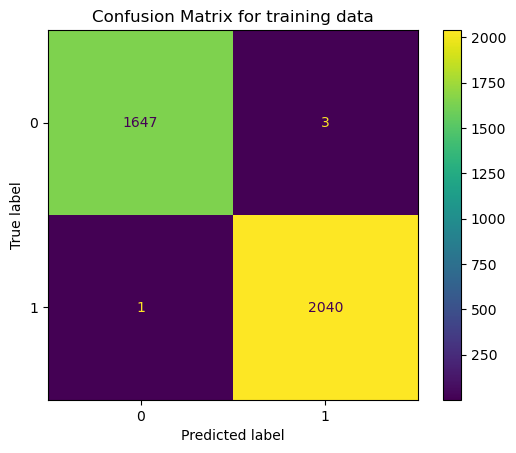

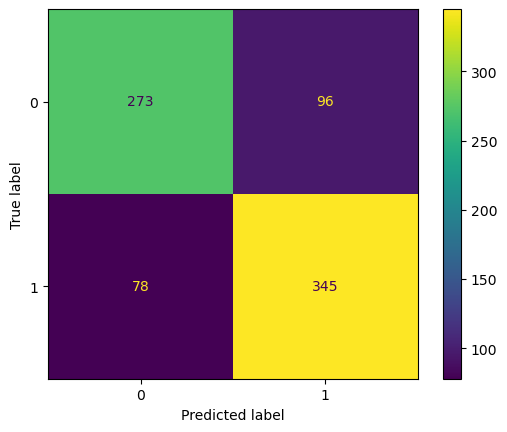

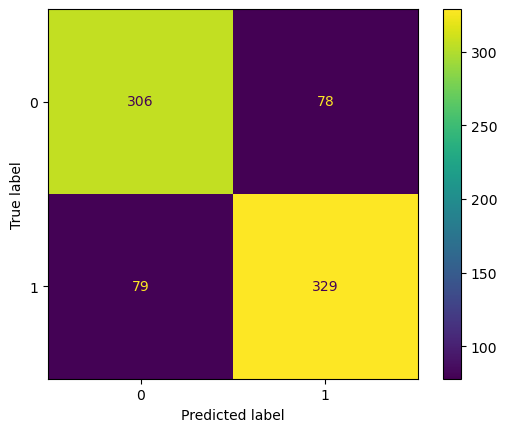

In [19]:
get_confusion_matrix(x_train, y_train, RFC_model, 'training') 
get_confusion_matrix(x_val, y_val, RFC_model, 'validation') 
get_confusion_matrix(x_test, y_test, RFC_model, 'test') 

In [ ]:
from sklearn.model_selection import  GridSearchCV

In [53]:
# grid search optimisation
grid_search_params = {
    'n_estimators' : np.linspace(450, 550, 5, dtype=int),
    'criterion' : ['gini'],
    'max_depth' : np.linspace(22, 32, 5, dtype=int),
    'min_samples_split' : [3,4,5],
    'min_samples_leaf' : [1,2],
    'max_features' : ['log2']
}

grid_search_RFC = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=grid_search_RFC, param_grid=grid_search_params, cv=5, n_jobs=-1, verbose=2, scoring='balanced_accuracy')
grid_search.fit(x_train, y_train_array)
best_RF_grid = grid_search.best_estimator_ # Get the best estimator from the grid search
y_pred = best_RF_grid.predict(x_test)
bacc = metrics.balanced_accuracy_score(y_test, y_pred)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
print(f"bacc: {bacc}")

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best parameters: {'criterion': 'gini', 'max_depth': np.int64(27), 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': np.int64(450)}
bacc: 0.8030024509803921


In [54]:
#should be looking at val stats not test stats!!!
y_pred_train = best_RF_grid.predict(x_train)
y_pred_val = best_RF_grid.predict(x_val)
bacc_train = metrics.balanced_accuracy_score(y_train, y_pred_train)
bacc_val = metrics.balanced_accuracy_score(y_val, y_pred_val)
print(f"bacc train: {bacc_train}")
print(f"bacc val: {bacc_val}")

bacc train: 0.9942168871468234
bacc val: 0.7870034019489132


c:\Users\nn21147\.conda\envs\chem-ml-env\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


accuracy: 0.9945814142508805
accuracy: 0.7790404040404041


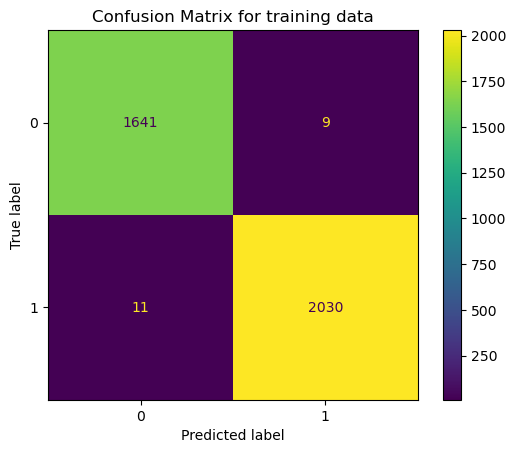

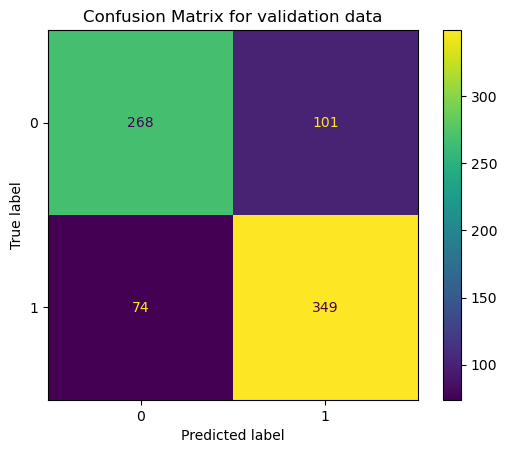

In [55]:
RFC_optimised = RandomForestClassifier(n_estimators=450, criterion='gini', max_depth=27, min_samples_split=5, min_samples_leaf=1, max_features='log2')
RFC_optimised_model = RFC_optimised.fit(x_train,y_train)

model_metrics(x_train, y_train, RFC_optimised_model)
model_metrics(x_val, y_val, RFC_optimised_model)

get_confusion_matrix(x_train, y_train, RFC_optimised_model, 'training') 
get_confusion_matrix(x_val, y_val, RFC_optimised_model, 'validation') 